##  Car Price Prediction - Preprocessing

###  Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#Python iterators for efficient looping
import itertools

#Hyperparameter selection
from sklearn.model_selection import ParameterGrid

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Import Raw Data

In [2]:
#Import data - austin, dallas, houston, and san antonio.  Two snapshots.

austin1=pd.read_json('json/austin_ford_2019-11-18.json')
dallas1=pd.read_json('json/dallas_ford_2019-11-18.json')
ep1=pd.read_json('json/ep_ford_2019-11-18.json')
houston1=pd.read_json('json/houston_ford_2019-11-18.json')
sa1=pd.read_json('json/sa_ford_2019_11_18.json')

austin2=pd.read_json('json/austin_ford_2019-12-29.json')
dallas2=pd.read_json('json/dallas_ford_2019-12-29.json')
ep2=pd.read_json('json/ep_ford_2019-12-29.json')
houston2=pd.read_json('json/houston_ford_2019-12-29.json')
sa2=pd.read_json('json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin1, dallas1, ep1, houston1, sa1, austin2, dallas2, ep2, houston2, sa2]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 21080 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
21079,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [3]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [4]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))

vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(1)

vehicle length: 21080
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...


In [5]:
#Helper functions.

def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return matchList

def findall_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        allm = re.findall(regex_patt, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:max_items]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList

def findall_body_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.
       Each Model included in pattern.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        patt_w_model = df.loc[idx, "Model"] + regex_patt  #regex pattern is: Model + Pattern
        allm = re.findall(patt_w_model, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:2]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList


#****************************************Target Encoder******************************************
from category_encoders.target_encoder import TargetEncoder

def target_encode_categ(encode_cols, train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and 
    (2) "Prior": ExpectedVal(Target) over all training data.  
    
    Sets testTarget to NaN to stop data leakage.
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    
    trn=train.copy(); tst=test.copy();
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test

def multivar_impute(train, test, target):
    '''Impute values with regression on numeric columns, excluding
    the target. Returns DataFrames.'''
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    num_cols_ex_targ = train.select_dtypes(exclude='object').columns.tolist()
    num_cols_ex_targ.remove(target)
    
    #Get imputed dfs.
    ii = IterativeImputer(max_iter=10, random_state=5)
    train_impX = pd.DataFrame(ii.fit_transform(train[num_cols_ex_targ]), index=train.index, columns=num_cols_ex_targ)
    test_impX = pd.DataFrame(ii.transform(test[num_cols_ex_targ]), index=test.index, columns=num_cols_ex_targ)

    #Overwrite original features with imputed features.
    train[num_cols_ex_targ] = train_impX
    test[num_cols_ex_targ] = test_impX
    return train, test

def norm_feat_1p(train, test, col_list):
    '''Return power-transformation of 1+feature and lambda dict.
    col_list is the list of features.'''
    from scipy.stats import boxcox
    lamDict={}
    for c in col_list:
        train[c], lam = boxcox(1 + train[c])
        test[c] = boxcox(1 + test[c], lmbda=lam)
        lamDict[c] = lam
        print(f'# Lambda for {c}:', lam)
    return train, test, lamDict

In [6]:
#Helper model to tune hyperparameters

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
    

def run_LGBM(train, test):    
    #Split out Price
    trainX = train.copy()
    trainY = trainX.pop('Price')
    testX = test.copy()
    testY = testX.pop('Price')
    display('Input data:', trainX.head(2))

    #CREATE LightGBM model with random search.

    clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

    param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
                "n_estimators": randint(100,200),
                "num_leaves": randint(2, 600), 
                "max_depth": randint(0, 40),
                "min_data_in_leaf": randint(10, 200),  #prevents overfitting
                "max_bin": randint(100,60000),
                "bagging_fraction": Real(0.01, 0.1, 'uniform'),
                "feature_fraction": uniform(0.01, 0.99),
                "subsample_for_bin": randint(100000, 600000),
                "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
                "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
                }

    #Instantiate random_search.
    lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                               scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

    #Tune model with CV. Model will automatically refit on full train with best parameters.
    lgb_model.fit(trainX, trainY)

    #Tuned model best score.
    best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
    print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
    mean_score = np.round(lgb_model.cv_results_["mean_test_score"],0)
    print(f'## mean valid scores: {mean_score})', '\n')
    print(f'## best valid score: {lgb_model.best_score_:.0f} +- {best_score_std:.0f}','\n')   
    print('## Best parameters:')
    pprint.pprint(lgb_model.best_params_)
    print('\n')

    #PREDICT model on full data (thanks to refit).
    y_test_pred = lgb_model.predict(testX)
          
    #Score algorithm
    mean_abs_error = score_algo(lgb_model, testX, testY, y_test_pred)        

    #Get feature importances using eli5.
    perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
    display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))
    return lgb_model, round(lgb_model.best_score_,1), round(best_score_std,1), round(mean_abs_error,1)

#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    mean_abs_err = round(mean_absolute_error(y, prediction),1)
    print(' MAE:', mean_abs_err)
    return mean_abs_err

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
# Residuals helper function
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

In [8]:
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

## In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.

## In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.



In [9]:
pd.set_option('max_colwidth', 80)
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083


In [10]:
#Drop incomplete listing 5247.
vehicle.drop(index = 5247, inplace = True)

In [11]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 1323


In [12]:
#EXTRACT Odometer & VIN from AttribDictionary.  
odomet=[]; vin = []; vinCNT=0;

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys(): #For each index, go through dict keys.
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                        
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing--not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

#SCRUB Odometer.
#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.  Mileage this low is likely invalid.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

#Fix odometer typo.
vehicle.loc[9196, 'Odometer'] = vehicle.loc[9196, 'Odometer'] / 1000
vehicle.loc[19738, 'Odometer'] = vehicle.loc[19738, 'Odometer'] / 1000

## In Body, 12530 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).



### Seller, Make, Model, Price, CombMPG, Displacement

In [13]:
#Create Seller feature using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [14]:
#Extract RawMake col from AttribDictionary in UPPERCASE.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1))
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [15]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [16]:
#Populate Make
make_regex=r'\s(ford)'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.
model_regex=r'(bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar)'
model_RawMake = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = model_RawMake

#Populate Model.
Model_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=model_regex, no_match_value='None')
vehicle['Model_Title'] = Model_Title
vehicle.loc[vehicle['Model'] == 'None', 'Model'] = vehicle.loc[vehicle['Model'] == 'None', 'Model_Title']

#Drop redundant column
vehicle.drop(['Model_Title'], axis='columns', inplace=True)

## In RawMake, 5 missed matches for regex pattern: \s(ford).

## In RawMake, 417 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar).

## In Title, 769 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln

In [17]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [18]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [19]:
#Insert CombMPG and displacement from modelYR.  
EPA = joblib.load('EPA.joblib')

#Backup vehicle indices before merge.
vehicle_idx_BAK = vehicle.index

#Merge data.  NOTE: Trim-level detail is unavailable in EPA data.  So ALL trim levels get the Model median.
#For example, a 2017 Mustang GT gets the same displacement as 2017 ecoboost.  More detail will improve the model.
vehicle = vehicle.merge(EPA, how='left', left_on=['Model','Year'], right_on=['clean_model','year'])

#Drop redundant columns.  Restore original vehicle indices that were reset by merge
vehicle.drop(columns=['clean_model', 'year'], inplace=True)
vehicle.rename(columns={'comb08' : 'CombMPG'}, inplace=True)
vehicle.index = vehicle_idx_BAK

In [20]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN


### Drop bad rows

In [21]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 317 TRUCKMAX listings outside Texas: Int64Index([ 1955,  2120,  2121,  2275,  2277,  2299,  2304,  2418,  2419,
             2554,
            ...
            20343, 20409, 20443, 20607, 20635, 20685, 20744, 20751, 20928,
            20937],
           dtype='int64', length=317)
Drop 5 non-ford makes: Int64Index([890, 5366, 9327, 15237, 19869], dtype='int64')


In [22]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Price is "NoneNoneNone"
filt = (vehicle['Price'] == 'NoneNoneNone')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} bad prices:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.  Stop code execution if NaNs exist.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  
#Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body']\
        + vehicle.loc[idx, 'SubLoc'] + " ", flags=re.IGNORECASE)
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'## Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

## Drop 2392 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            20999, 21013, 21014, 21023, 21033, 21035, 21041, 21047, 21060,
            21062],
           dtype='int64', length=2392) 

## Drop 1 bad prices: Int64Index([16842], dtype='int64')
## Drop 1054 DOWN prices under $5,001: Int64Index([    8,    79,    88,    96,   102,   141,   199,   200,   481,
              530,
            ...
            20938, 20956, 20961, 20984, 21016, 21026, 21032, 21038, 21039,
            21068],
           dtype='int64', length=1054)
## Drop 121 prices over $74,999 or under $501: Int64Index([  421,   597,   675,   921,  1393,  1545,  1916,  2014,  2162,
             2395,
            ...
            19570, 19812, 19839, 19884, 19961, 19967, 20444, 20492, 20757,
            20973],
           dtype='int64', length=121)


In [23]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799.0,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN,None
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2,2.0,25.0,None


In [24]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'cmax' : 'c-max', 'e150' : 'e-150', 'e250' : 'e-250', 'e350' : 'e-350',
                      'f150' : 'f-150', 'f250' : 'f-250', 'f350' : 'f-350', 'f450' : 'f-450',
                     }
            }

vehicle.replace(model_dict, inplace=True)

In [25]:
#Set Odometer=0 to NaN.
odZeroFilt = (vehicle['Odometer'] == 0)
zero_indices = vehicle[odZeroFilt].index
print(f'# {len(zero_indices)} Odometer values are zero.  Set to NaN.', zero_indices)
vehicle.loc[zero_indices, 'Odometer'] = np.nan

#Drop duplicate VINs.
print('\n# Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

#Drop listings with the same Title/Odometer/Price.
print('\n# Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

# 34 Odometer values are zero.  Set to NaN. Int64Index([    6,     9,    10,   178,   573,  1338,  1414,  1415,  1449,
             1450,  2189,  5072,  6073,  7020,  8619,  8655, 10616, 10645,
            11578, 12009, 12011, 12133, 12158, 12159, 12162, 13070, 13489,
            13793, 14090, 17026, 17632, 17975, 19161, 19197],
           dtype='int64')

# Duplicate VINs dropped: 3818

# Duplicate Vehicles dropped: 2232


### Drop missing and commercial Models that lack EPA data.

In [26]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove f-250, f-350, and f-450 -- no EPA data.  These vehicles are commercial, not personal.
filt = (vehicle['Model'] == 'f-250') | (vehicle['Model'] == 'f-350') | (vehicle['Model'] == 'f-450')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "f-250", "f-350", or "f-450":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

# Drop 57 Models that are "None": Int64Index([  257,   423,   556,   805,   828,  1204,  1372,  1614,  1990,
             2042,  2078,  2552,  3586,  4043,  4439,  4606,  5385,  5435,
             5436,  5678,  7271,  8506,  8905,  9019,  9413,  9484,  9563,
             9863, 10091, 10605, 10734, 11137, 11418, 11546, 11698, 11708,
            11761, 11943, 11990, 12082, 12454, 12513, 12783, 12861, 13948,
            14126, 14391, 15074, 15332, 15880, 16447, 16896, 16903, 17157,
            17297, 17398, 18737],
           dtype='int64')
# Drop 2216 Models that are "f-250", "f-350", or "f-450": Int64Index([    0,     2,     5,     7,    13,    18,    28,    30,    32,
               49,
            ...
            18746, 18747, 18748, 18749, 18751, 18752, 18754, 18759, 18761,
            18772],
           dtype='int64', length=2216)


In [27]:
# +++++++++++++++++ DROP OUTLIERS ++++++++++++++++++++++++

# 7504 from Year 1997 is a crane.
# 16986 from Year 2008 has low mileage, high price.
# 15627 from 2008 has high price for expedition and listing is garbled.
# 7413 from 2017 is listed used above MSRP.
# 13711 is listed above MSRP and CraigsList trim is incorrect.

drop_indices = [7504, 16986, 15627, 7413, 13711]
print(f'Drop {len(drop_indices)} outliers:', drop_indices)
vehicle = vehicle.drop(index = drop_indices)

Drop 5 outliers: [7504, 16986, 15627, 7413, 13711]


In [28]:
vehicle.columns

Index(['URL_Vehicle', 'Title', 'Location', 'Year', 'Year_in_Title', 'Odometer',
       'RawMake', 'Make', 'Model', 'Trim', 'Seller', 'Price', 'SubLoc', 'Body',
       'AttribDictionary', 'ImageDictionary', 'VehicleID', 'VIN', 'displ',
       'CombMPG', 'DownFlag'],
      dtype='object')

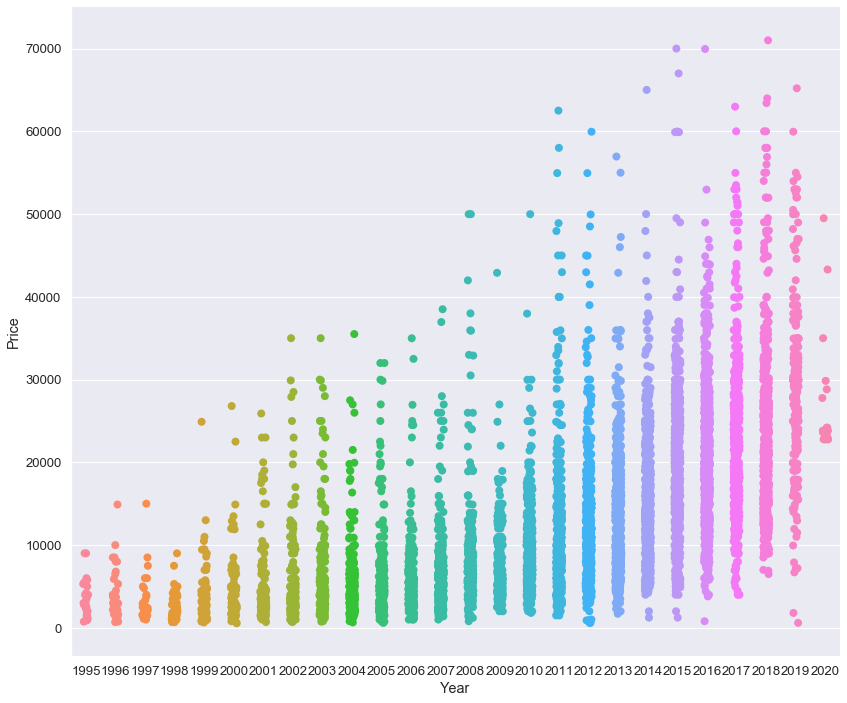

In [29]:
#Catplot by Year and Price.  Looks like Year^2 could be a good feature!
sns.set(font_scale=1.2)
c = sns.catplot(x='Year',y='Price', data=vehicle, height=10, aspect=1.2, s=8)  #s changes marker size
c.set_xticklabels(rotation=0)
plt.show()

In [30]:
#Transform features.
vehicle['Year' + '^2'] = vehicle['Year']**2

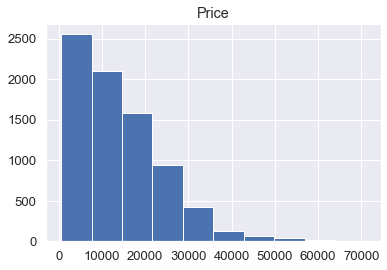

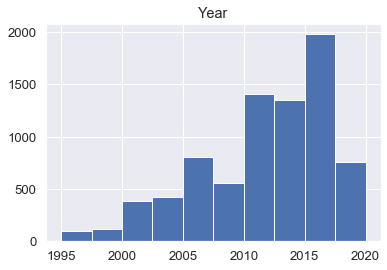

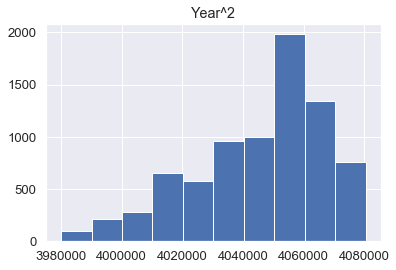

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


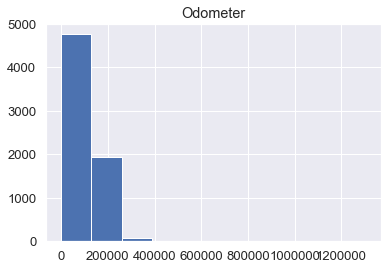

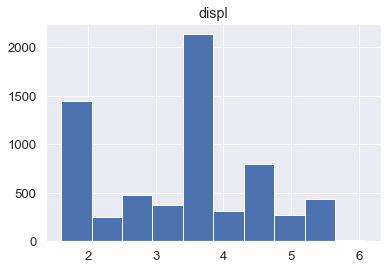

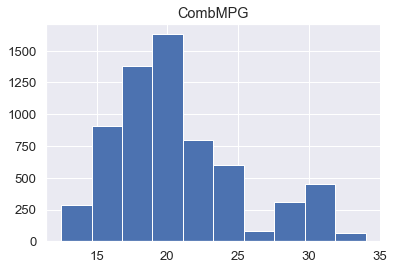

In [31]:
#Histogram of numeric features
for f in ['Price', 'Year', 'Year^2', 'Odometer', 'displ', 'CombMPG']:
    plt.hist(vehicle[f])
    plt.title(f)
    plt.show()

In [32]:
### Build Trim features function

def build_trim_feats(dframe, maxi_trims, min_trim_samp):
    '''
    Return DataFrame with new Trim features.
    
    Arguments
    ---------
    dframe: DataFrame containing model data
    maxi_trims: Max allowed trims -- 1 or 2.
    min_trim_samp: Min count of Model_Trim allowed.  Ex. Min 40 Mustang_GT samples.    
    '''
    
    df1=dframe.copy()
    #Populate max two Trim from RawMake.  Case Insensitive.
    trim_regex=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)'
    trim_RawMake = findall_regex_patt(df=df1, target_col='RawMake', regex_patt=trim_regex, max_items=maxi_trims)    
    df1['Trim_RawMake'] = trim_RawMake

    #Populate max two Trim from Title.  Case Insensitive.
    trim_Title = findall_regex_patt(df=df1, target_col='Title', regex_patt=trim_regex, max_items=maxi_trims)
    df1['Trim_Title'] = trim_Title

    #Populate max two Trim from Body.  Model is prefix of search pattern.
    trim_regex_spaces=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)\s'
    trim_Body=findall_body_regex_patt(df=df1,target_col='Body',regex_patt=trim_regex_spaces,max_items=maxi_trims)
    df1['Trim_Body'] = trim_Body

    #Scrub Trim in order:  Trim_RawMake, Trim_Title, Trim_Body.
    df1.loc[df1['Trim'].isna(), 'Trim'] = df1.loc[df1['Trim'].isna(), 'Trim_RawMake']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Title']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Body']

    #Drop redundant Trim columns.
    df1.drop(['Trim_RawMake','Trim_Title','Trim_Body'], axis='columns', inplace=True)

    #Create Model_Trim feature
    df1['Model_Trim'] = df1['Model'] + '_' + df1['Trim']

    #Remove df1 'Model_Trim' counts under threshold.
    thresh=min_trim_samp
    trim_counts=df1['Model_Trim'].value_counts()             
    #print(f'\nDropping Trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
    trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
    df1= df1[df1['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
    print(f'\nOver {thresh} threshold trims:\n', df1['Model_Trim'].value_counts())
    
    #Create Model_Trim_Year feature.  Fixes linear model residuals.
    df1['Year'] = df1['Year'].apply(lambda y: str(y))
    df1['Model_Trim_Year'] = df1['Model'] + '_' + df1['Trim'] + '_' + df1['Year']
    df1['Year'] = df1['Year'].astype('int64')
    return df1

In [33]:
vehicle.isna().sum()

URL_Vehicle            0
Title                  0
Location               0
Year                   0
Year_in_Title       7864
Odometer            1074
RawMake                0
Make                   0
Model                  0
Trim                7864
Seller                 0
Price                  0
SubLoc                 0
Body                   0
AttribDictionary       0
ImageDictionary        0
VehicleID              0
VIN                    0
displ               1351
CombMPG             1351
DownFlag               0
Year^2                 0
dtype: int64

## Parameter Search with Trim and Target Encode Hyperparameters

In [34]:
def hyperparam_search(max_trims, min_trim_samp, min_leaf_samp, smooth):    
    '''Grid search for hyperparameters.'''

    par_grid = {'max_trims': max_trims,'min_trim_samp': min_trim_samp, 'min_leaf_samp': min_leaf_samp, 'smooth': smooth}
    print('grid:', par_grid, '\n')
    pg=ParameterGrid(par_grid)

    #Try each hyperparameter combo.
    results = []
    for gr in pg:  

        #Get Trim for hyperparameter pick: maxi_trims and min_trim_samp.
        tempDF = build_trim_feats(dframe=vehicle, maxi_trims=gr['max_trims'], min_trim_samp=gr['min_trim_samp'])

        #Stratify data - depends on Trim pick.
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
        for train_index, test_index in sss.split(tempDF, tempDF['Model_Trim']):  #split indices as ilocs
            train = tempDF.iloc[train_index]
            test = tempDF.iloc[test_index]

        #Drop irrelevant columns.
        irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body',\
                      'AttribDictionary', 'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']
        train = train.drop(irrel_cols, axis='columns', errors='ignore')
        test = test.drop(irrel_cols, axis='columns', errors='ignore')

        #Target Encode category features with train: Price.
        te_cols = ['Seller', 'Model_Trim_Year']
        train, test=target_encode_categ(encode_cols=te_cols, train=train, test=test, target='Price',\
                   encoder=TargetEncoder(cols=te_cols, min_samples_leaf=gr['min_leaf_samp'],smoothing=gr['smooth']))

        #*******************************************************************************************        
      
        #Impute missing values - displ, CombMPG Odometer - by regressing on all other features.
        train, test = multivar_impute(train, test,'Price')
        
        #Drop any understated odometer values.
        filt_used_under_1K = (train['Odometer'] < 1000) & (train['Year^2'] < 2020**2)
        drop_indices = train[filt_used_under_1K].index
        print(f'Drop {len(drop_indices)} incorrect low mileage from train:', drop_indices)
        train = train.drop(index = drop_indices, errors = 'ignore')

        filt_used_under_1K = (test['Odometer'] < 1000) & (test['Year^2'] < 2020**2)
        drop_indices = test[filt_used_under_1K].index
        print(f'# Drop {len(drop_indices)} incorrect low mileage from test:', drop_indices)
        test = test.drop(index = drop_indices, errors = 'ignore')

        #Drop anomaly odometer values.
        filt_over_1M = train['Odometer'] > 400_000
        drop_indices = train[filt_over_1M].index
        print(f'# Drop {len(drop_indices)} incorrect high mileage from train:', drop_indices)
        train = train.drop(index = drop_indices, errors = 'ignore')

        filt_over_1M = test['Odometer'] > 400_000
        drop_indices = test[filt_over_1M].index
        print(f'# Drop {len(drop_indices)} incorrect high mileage from test:', drop_indices)
        test = test.drop(index = drop_indices, errors = 'ignore')
               
        #*******************************************************************************************

        #User drops certain collinear or noise features.
        user_drops = ['Location', 'Model', 'Trim', 'Year', 'Model_Trim']
        train = train.drop(user_drops, axis='columns', errors='ignore')
        test = test.drop(user_drops, axis='columns', errors='ignore')

        #Run LightGBM fit and predict.
        lgb_model, valid_mae, valid_std, test_mae = run_LGBM(train, test)

        #Save Results
        results.append([gr['max_trims'], gr['min_trim_samp'], gr['min_leaf_samp'], gr['smooth'],\
                        -valid_mae, valid_std, test_mae, round(-test_mae/valid_mae*100,1)])
    return results, train, test

#Run hyperparameter grid search.
par_grid = {'max_trims':[2], 'min_trim_samp':[40], 'min_leaf_samp':[1,2,3,4], 'smooth':[0.3,0.5,1,2]}
results, _ , _ = hyperparam_search(**par_grid)  #unpack dictionary arguments

grid: {'max_trims': [2], 'min_trim_samp': [40], 'min_leaf_samp': [1, 2, 3, 4], 'smooth': [0.3, 0.5, 1, 2]} 

## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSI

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,87810.341659,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5187.812312


## Grid iters checked: 30 

## mean valid scores: [-2167. -2110. -2058. -2301. -2114. -2280. -2441. -2136. -2116. -3194.
 -2435. -2059. -2167. -3817. -2096. -2205. -2061. -2105. -2082. -2077.
 -2086. -2059. -2588. -2250. -3128. -2023. -2076. -2063. -2039. -2047.]) 

## best valid score: -2023 +- 67 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3127.5
 R^2: 0.8848
 MAE: 2094.7


Weight,Feature
4479.0140 ± 328.6325,Model_Trim_Year
1418.4375 ± 175.8856,Odometer
582.8562 ± 95.8255,Year^2
423.0536 ± 91.9913,CombMPG
287.7678 ± 62.7108,displ
198.5663 ± 54.6690,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,87915.485371,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5190.349210


## Grid iters checked: 30 

## mean valid scores: [-2170. -2121. -2066. -2309. -2122. -2301. -2445. -2137. -2135. -3195.
 -2440. -2065. -2191. -3816. -2099. -2206. -2066. -2099. -2096. -2092.
 -2116. -2070. -2589. -2253. -3128. -2038. -2078. -2060. -2051. -2052.]) 

## best valid score: -2038 +- 62 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3132.4
 R^2: 0.8844
 MAE: 2109.4


Weight,Feature
4605.8692 ± 340.1484,Model_Trim_Year
1426.5757 ± 198.8261,Odometer
554.2963 ± 84.6949,Year^2
410.7817 ± 102.6546,CombMPG
289.5637 ± 70.4144,displ
191.6913 ± 53.6856,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88153.555689,15621.205693,2.0,28.0,4056196.0,9337.293517
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5324.524635


## Grid iters checked: 30 

## mean valid scores: [-2179. -2131. -2090. -2308. -2156. -2295. -2451. -2162. -2144. -3205.
 -2465. -2086. -2183. -3822. -2122. -2225. -2093. -2123. -2122. -2114.
 -2127. -2090. -2596. -2278. -3134. -2057. -2104. -2090. -2069. -2071.]) 

## best valid score: -2057 +- 56 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3124.6
 R^2: 0.885
 MAE: 2103.6


Weight,Feature
4425.0756 ± 271.9420,Model_Trim_Year
1476.7879 ± 147.1357,Odometer
579.0556 ± 109.2770,Year^2
415.7166 ± 78.0264,CombMPG
317.4768 ± 71.7923,displ
189.8169 ± 64.1252,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88469.164407,15621.205693,2.0,28.0,4056196.0,9342.468022
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,6093.937316


## Grid iters checked: 30 

## mean valid scores: [-2191. -2130. -2102. -2333. -2157. -2301. -2467. -2174. -2157. -3212.
 -2481. -2112. -2190. -3825. -2120. -2242. -2116. -2130. -2144. -2125.
 -2147. -2111. -2608. -2271. -3136. -2087. -2113. -2096. -2085. -2093.]) 

## best valid score: -2085 +- 64 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3090.3
 R^2: 0.8875
 MAE: 2094.5


Weight,Feature
4653.8284 ± 458.1327,Model_Trim_Year
1541.8187 ± 203.2013,Odometer
721.7562 ± 122.4281,Year^2
530.7422 ± 115.0484,CombMPG
272.9766 ± 70.2181,displ
181.1244 ± 37.6759,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88216.580677,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5188.145098


## Grid iters checked: 30 

## mean valid scores: [-2215. -2146. -2109. -2338. -2166. -2331. -2465. -2194. -2170. -3219.
 -2478. -2113. -2226. -3820. -2148. -2260. -2121. -2145. -2146. -2128.
 -2150. -2120. -2609. -2293. -3141. -2086. -2131. -2113. -2091. -2104.]) 

## best valid score: -2086 +- 65 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3161.5
 R^2: 0.8823
 MAE: 2112.5


Weight,Feature
4387.9956 ± 351.6135,Model_Trim_Year
1415.5398 ± 144.8087,Odometer
705.3948 ± 108.0013,Year^2
371.1421 ± 73.4249,CombMPG
335.1979 ± 61.4518,displ
183.3762 ± 45.9198,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88282.965158,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5206.595983


## Grid iters checked: 30 

## mean valid scores: [-2209. -2153. -2111. -2338. -2169. -2324. -2468. -2196. -2192. -3217.
 -2482. -2118. -2223. -3824. -2141. -2262. -2125. -2149. -2148. -2136.
 -2166. -2126. -2614. -2296. -3140. -2087. -2127. -2109. -2099. -2105.]) 

## best valid score: -2087 +- 62 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3157.7
 R^2: 0.8826
 MAE: 2109.6


Weight,Feature
4353.1593 ± 395.5816,Model_Trim_Year
1415.2377 ± 205.6911,Odometer
728.5143 ± 139.0930,Year^2
385.4784 ± 66.0983,CombMPG
313.2055 ± 51.7738,displ
183.0037 ± 41.0723,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88438.396728,15621.205693,2.0,28.0,4056196.0,9337.306925
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5548.314262


## Grid iters checked: 30 

## mean valid scores: [-2214. -2161. -2120. -2334. -2174. -2332. -2475. -2199. -2187. -3222.
 -2484. -2123. -2221. -3829. -2129. -2262. -2128. -2159. -2151. -2131.
 -2158. -2131. -2615. -2287. -3140. -2099. -2119. -2121. -2103. -2103.]) 

## best valid score: -2099 +- 65 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3202.5
 R^2: 0.8792
 MAE: 2137.3


Weight,Feature
4156.2102 ± 391.7479,Model_Trim_Year
1430.1418 ± 150.5562,Odometer
802.6682 ± 135.6761,Year^2
391.5696 ± 70.6515,displ
365.3669 ± 63.1071,CombMPG
207.9355 ± 46.5671,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88678.256526,15621.205693,2.0,28.0,4056196.0,9345.821583
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,6574.532571


## Grid iters checked: 30 

## mean valid scores: [-2219. -2173. -2133. -2366. -2183. -2358. -2490. -2209. -2189. -3231.
 -2507. -2139. -2215. -3833. -2155. -2285. -2147. -2166. -2174. -2151.
 -2177. -2143. -2625. -2318. -3148. -2121. -2145. -2130. -2116. -2124.]) 

## best valid score: -2116 +- 63 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3155.4
 R^2: 0.8827
 MAE: 2116.4


Weight,Feature
4590.9588 ± 425.8159,Model_Trim_Year
1581.7908 ± 189.8022,Odometer
733.1933 ± 115.7955,Year^2
418.1829 ± 87.1666,CombMPG
400.2162 ± 115.5527,displ
187.8815 ± 43.6416,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88446.139006,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5197.461804


## Grid iters checked: 30 

## mean valid scores: [-2268. -2184. -2137. -2449. -2213. -2363. -2508. -2254. -2196. -3287.
 -2521. -2171. -2264. -3855. -2163. -2369. -2174. -2210. -2222. -2164.
 -2175. -2169. -2668. -2299. -3184. -2137. -2140. -2145. -2116. -2137.]) 

## best valid score: -2116 +- 80 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3359.6
 R^2: 0.8671
 MAE: 2244.2


Weight,Feature
4101.9271 ± 458.7089,Model_Trim_Year
1619.4672 ± 243.0739,Odometer
1021.3248 ± 109.2721,Year^2
579.1821 ± 81.0456,displ
523.5224 ± 118.9978,CombMPG
213.3311 ± 61.3508,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88520.076793,15621.205693,2.0,28.0,4056196.0,9337.285715
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5324.524635


## Grid iters checked: 30 

## mean valid scores: [-2275. -2186. -2144. -2429. -2231. -2379. -2518. -2267. -2215. -3273.
 -2536. -2177. -2266. -3851. -2186. -2375. -2184. -2212. -2224. -2176.
 -2192. -2178. -2661. -2332. -3176. -2157. -2166. -2146. -2135. -2154.]) 

## best valid score: -2135 +- 76 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3179.7
 R^2: 0.8809
 MAE: 2144.4


Weight,Feature
4137.4522 ± 376.9924,Model_Trim_Year
1602.9328 ± 186.5536,Odometer
1059.0607 ± 192.9015,Year^2
630.3840 ± 130.2385,displ
518.1258 ± 103.5189,CombMPG
203.5434 ± 55.1871,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88665.700232,15621.205693,2.0,28.0,4056196.0,9337.343370
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,6093.937316


## Grid iters checked: 30 

## mean valid scores: [-2265. -2194. -2159. -2417. -2208. -2364. -2517. -2264. -2189. -3263.
 -2545. -2182. -2256. -3848. -2172. -2347. -2190. -2225. -2221. -2158.
 -2173. -2180. -2657. -2289. -3169. -2151. -2160. -2145. -2143. -2158.]) 

## best valid score: -2143 +- 65 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3139.5
 R^2: 0.8839
 MAE: 2120.7


Weight,Feature
4245.1801 ± 365.7122,Model_Trim_Year
1555.7690 ± 169.5465,Odometer
1013.6992 ± 167.8981,Year^2
556.2410 ± 88.2747,displ
496.8082 ± 77.4829,CombMPG
222.9630 ± 74.2882,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88869.057749,15621.205693,2.0,28.0,4056196.0,9351.336445
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,7232.195000


## Grid iters checked: 30 

## mean valid scores: [-2249. -2173. -2139. -2403. -2188. -2346. -2506. -2239. -2194. -3248.
 -2537. -2179. -2242. -3841. -2142. -2327. -2192. -2189. -2208. -2157.
 -2179. -2176. -2652. -2309. -3160. -2151. -2146. -2132. -2141. -2141.]) 

## best valid score: -2132 +- 61 

## Best parameters:
{'bagging_fraction': array([0.03615057]),
 'feature_fraction': 0.5551572704011554,
 'lambda_l1': array([0.22935178]),
 'lambda_l2': array([22.20695881]),
 'learning_rate': array([0.29182113]),
 'max_bin': 31461,
 'max_depth': 29,
 'min_data_in_leaf': 105,
 'n_estimators': 199,
 'num_leaves': 243,
 'subsample_for_bin': 468038}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3145.2
 R^2: 0.8835
 MAE: 2107.8


Weight,Feature
3196.4078 ± 168.8540,Model_Trim_Year
1775.5134 ± 213.4058,Odometer
1613.5634 ± 188.8997,Year^2
842.3279 ± 111.1818,CombMPG
544.6949 ± 117.7799,displ
217.6000 ± 73.8314,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88370.981035,15621.205693,2.0,28.0,4056196.0,9337.285714
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,5449.639866


## Grid iters checked: 30 

## mean valid scores: [-2297. -2182. -2144. -2549. -2209. -2371. -2523. -2280. -2201. -3346.
 -2537. -2199. -2262. -3884. -2153. -2456. -2210. -2239. -2258. -2152.
 -2178. -2204. -2709. -2305. -3216. -2162. -2139. -2145. -2131. -2144.]) 

## best valid score: -2131 +- 84 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3289.9
 R^2: 0.8725
 MAE: 2191.0


Weight,Feature
3968.8638 ± 294.2721,Model_Trim_Year
1694.3197 ± 198.0915,Odometer
1002.1263 ± 153.2631,Year^2
562.6910 ± 108.4302,displ
529.4837 ± 105.0199,CombMPG
210.8584 ± 77.2570,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88487.744523,15621.205693,2.0,28.0,4056196.0,9337.285721
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,6093.937316


## Grid iters checked: 30 

## mean valid scores: [-2315. -2182. -2156. -2549. -2219. -2364. -2552. -2303. -2213. -3338.
 -2589. -2221. -2269. -3880. -2173. -2462. -2228. -2262. -2272. -2176.
 -2177. -2222. -2701. -2329. -3214. -2175. -2152. -2162. -2146. -2171.]) 

## best valid score: -2146 +- 75 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3369.1
 R^2: 0.8663
 MAE: 2225.5


Weight,Feature
3737.3960 ± 330.1784,Model_Trim_Year
1747.5341 ± 202.6409,Odometer
1246.6745 ± 161.9367,Year^2
724.2544 ± 148.1152,displ
554.7825 ± 87.2247,CombMPG
204.9219 ± 75.5066,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88756.748879,15621.205693,2.0,28.0,4056196.0,9337.442435
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,7232.195000


## Grid iters checked: 30 

## mean valid scores: [-2308. -2201. -2171. -2498. -2219. -2348. -2536. -2291. -2216. -3313.
 -2598. -2234. -2273. -3861. -2173. -2433. -2244. -2251. -2273. -2181.
 -2197. -2228. -2683. -2329. -3198. -2188. -2172. -2171. -2157. -2181.]) 

## best valid score: -2157 +- 69 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3181.7
 R^2: 0.8808
 MAE: 2149.5


Weight,Feature
3838.3825 ± 305.5236,Model_Trim_Year
1535.8413 ± 217.5551,Odometer
1325.6762 ± 186.8008,Year^2
731.5675 ± 118.9000,displ
539.6220 ± 80.8998,CombMPG
211.0010 ± 43.8443,Seller


## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,89011.980358,15621.205693,2.0,28.0,4056196.0,9360.390447
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,8057.727033


## Grid iters checked: 30 

## mean valid scores: [-2303. -2185. -2162. -2459. -2205. -2378. -2524. -2276. -2224. -3290.
 -2571. -2229. -2257. -3853. -2170. -2386. -2235. -2241. -2260. -2175.
 -2195. -2228. -2681. -2313. -3183. -2176. -2176. -2161. -2159. -2173.]) 

## best valid score: -2159 +- 54 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3193.2
 R^2: 0.8799
 MAE: 2163.0


Weight,Feature
3875.6599 ± 400.9743,Model_Trim_Year
1604.2388 ± 205.2139,Odometer
1167.6630 ± 153.3240,Year^2
608.2289 ± 85.5188,displ
445.2096 ± 74.5414,CombMPG
217.6756 ± 55.3101,Seller


In [35]:
#Show scores in a table.
scores = pd.DataFrame(results, columns=['max_trims', 'min_trim_samp', 'min_leaf_samp','smooth',\
                                        'valid_MAE','valid_std', 'test_mae','overfit_ratio'])

display(scores)

#Save best hyperparams.
filt_min_idx = [scores.loc[scores['overfit_ratio'] >= 99.9, 'test_mae'].idxmin()]
best_hyp = scores.loc[filt_min_idx]
max_trims1 = best_hyp['max_trims'].to_numpy()
min_trim_samp1 = best_hyp['min_trim_samp'].to_numpy()
min_leaf_samp1 = best_hyp['min_leaf_samp'].to_numpy()
smooth1 = best_hyp['smooth'].to_numpy()

display(best_hyp)

,max_trims,min_trim_samp,min_leaf_samp,smooth,valid_MAE,valid_std,test_mae,overfit_ratio
0,2,40,1,0.3,2022.8,66.6,2094.7,103.6
1,2,40,1,0.5,2038.0,61.9,2109.4,103.5
2,2,40,1,1.0,2057.1,56.2,2103.6,102.3
3,2,40,1,2.0,2084.7,63.8,2094.5,100.5
4,2,40,2,0.3,2086.5,65.0,2112.5,101.2
5,2,40,2,0.5,2087.2,61.9,2109.6,101.1
6,2,40,2,1.0,2098.6,64.8,2137.3,101.8
7,2,40,2,2.0,2115.9,63.3,2116.4,100.0
8,2,40,3,0.3,2116.2,80.0,2244.2,106.0
9,2,40,3,0.5,2134.8,76.4,2144.4,100.4


,max_trims,min_trim_samp,min_leaf_samp,smooth,valid_MAE,valid_std,test_mae,overfit_ratio
3,2,40,1,2.0,2084.7,63.8,2094.5,100.5


In [36]:
#scores.sort_values(by='test_mae')

In [37]:
#Get train and test with the best hyperparam encoding.
param_grid = {'max_trims':max_trims1, 'min_trim_samp':min_trim_samp1, 'min_leaf_samp':min_leaf_samp1, 'smooth':smooth1}
results, train, test = hyperparam_search(**param_grid)  #unpack dictionary to function arguments

grid: {'max_trims': array([2], dtype=int64), 'min_trim_samp': array([40], dtype=int64), 'min_leaf_samp': array([1], dtype=int64), 'smooth': array([2.])} 

## In RawMake, 5129 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2051 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATIN

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7236,88469.164407,15621.205693,2.0,28.0,4056196.0,9342.468022
17996,94081.000000,15621.205693,4.6,15.0,4020025.0,6093.937316


## Grid iters checked: 30 

## mean valid scores: [-2191. -2130. -2102. -2333. -2157. -2301. -2467. -2174. -2157. -3212.
 -2481. -2112. -2190. -3825. -2120. -2242. -2116. -2130. -2144. -2125.
 -2147. -2111. -2608. -2271. -3136. -2087. -2113. -2096. -2085. -2093.]) 

## best valid score: -2085 +- 64 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3090.3
 R^2: 0.8875
 MAE: 2094.5


Weight,Feature
4726.5372 ± 385.5035,Model_Trim_Year
1601.2553 ± 169.2879,Odometer
707.7381 ± 125.0606,Year^2
505.4298 ± 95.2087,CombMPG
256.3174 ± 54.0198,displ
193.7806 ± 53.1759,Seller


### Train Plots - Best Hyperparameters

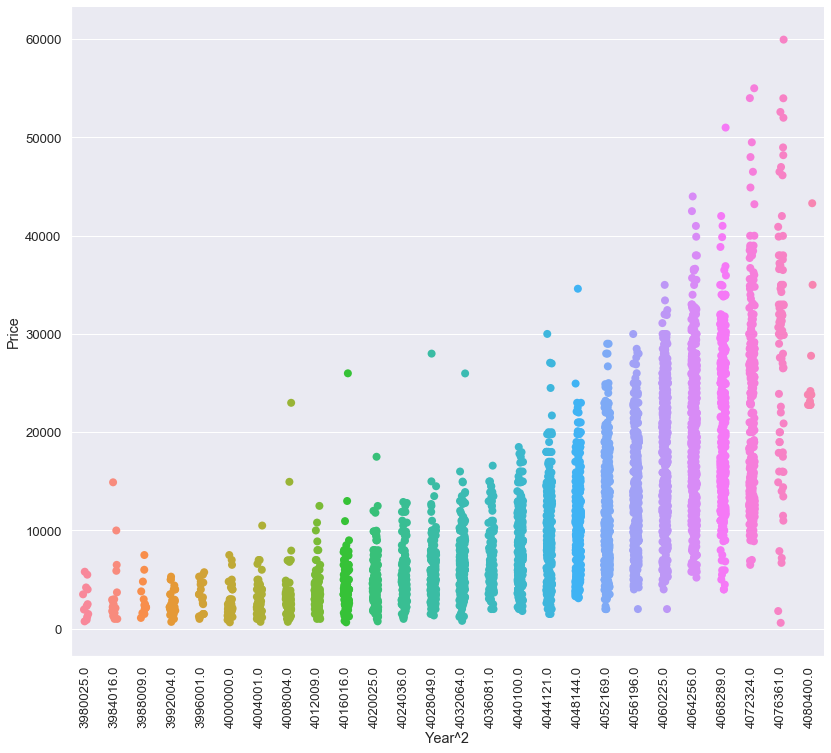

There are 559 unique Model_Trim_Year combos.  High cardinality.


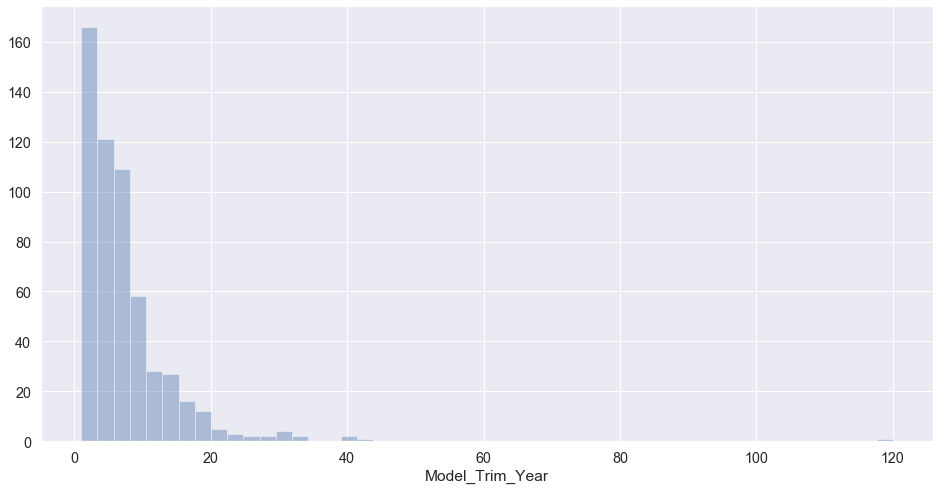

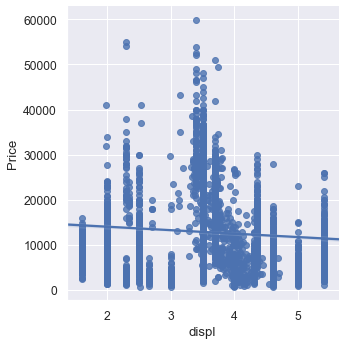

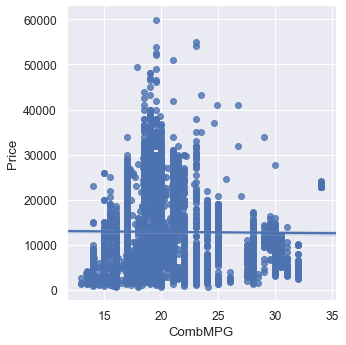

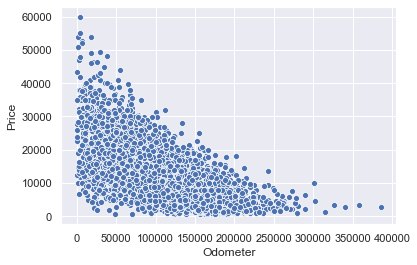

In [39]:
#PLOTS
mydf=train

#Catplot by Year^2 and Price.  Dumping uncommon Model_Trim removed most Price anomalies above "x^2 curve"!
sns.set(font_scale=1.2)
c2 = sns.catplot(x='Year^2',y='Price', data=mydf, height=10, aspect=1.2, s=8)  #s changes marker size
c2.set_xticklabels(rotation=90)
plt.show()

#Model_Trim_Year has rare categories, so target encoding will need regularization.
print(f"There are {len(mydf['Model_Trim_Year'].value_counts())} unique Model_Trim_Year combos.  High cardinality.")
plt.figure(figsize=(16,8))
sns.set(font_scale=1.3)
sns.distplot(mydf['Model_Trim_Year'].value_counts(), kde=False)
plt.show()
    
#Scatter by Displacement vs Price, and Model.
sns.set(font_scale=1.1)
sns.lmplot(x='displ',y='Price',data=mydf)  #s changes marker size
plt.show()

#Scatter by MPG vs Price.
sns.set(font_scale=1.1)
sns.lmplot(x='CombMPG',y='Price',data=mydf)  #s changes marker size
plt.show()

#Scatter by Odometer vs Price.  Will drop mileages over 400K.
sns.set(font_scale=1.0)
sns.scatterplot(x='Odometer',y='Price',data=mydf)  #s changes marker size
plt.show() 

In [40]:
train.describe()

,Odometer,Seller,Price,displ,CombMPG,Year^2,Model_Trim_Year
count,4106.000000,4106.000000,4106.000000,4106.000000,4106.000000,4.106000e+03,4106.000000
mean,101511.708671,12810.515688,12829.593035,3.494669,20.454442,4.046688e+06,12998.994422
std,56589.808410,3716.867920,8948.258157,1.060486,4.583691,2.086575e+04,7538.459310
min,4.000000,7896.511475,600.000000,1.600000,13.000000,3.980025e+06,1611.907148
25%,56002.574378,7896.511475,5500.000000,2.500000,17.000000,4.032064e+06,6813.114971
50%,98340.900820,15621.205693,10956.000000,3.500000,19.500000,4.052169e+06,11793.313791
75%,142625.250000,15621.205693,18464.750000,4.300000,23.000000,4.064256e+06,17585.329156
max,386000.000000,15621.205693,59950.000000,5.400000,34.000000,4.080400e+06,42680.614641


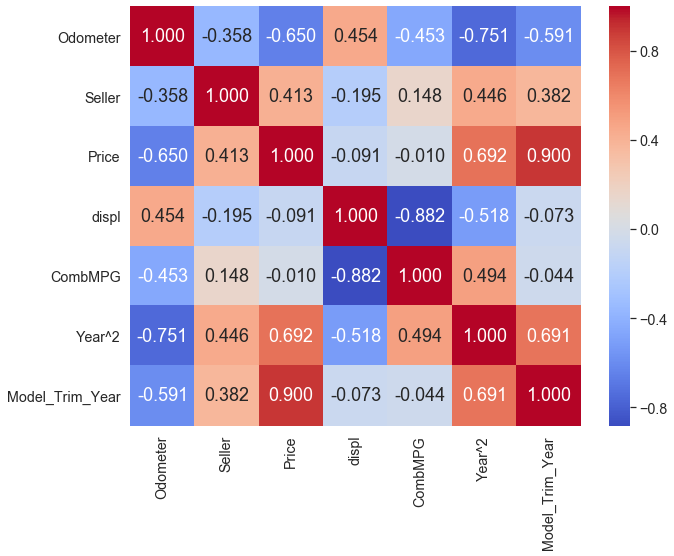

In [41]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.set(font_scale=1.3)
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

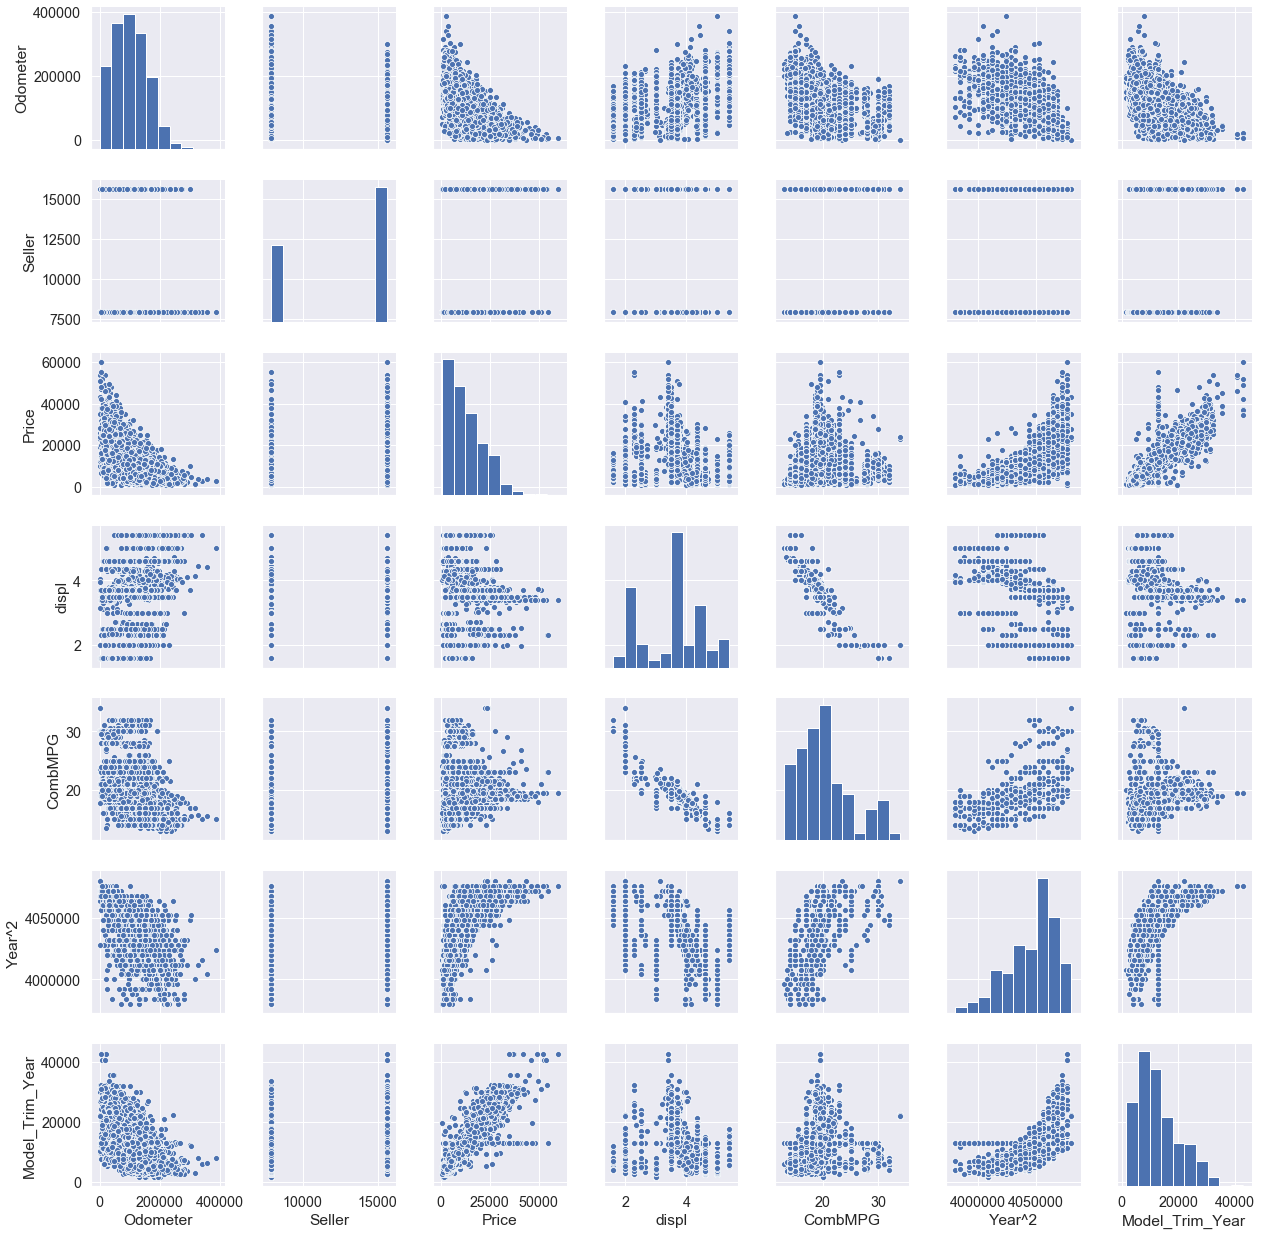

In [42]:
#Investigate outliers revealed in pairplot.
sns.set(font_scale=1.3)
sns.pairplot(train)
plt.show()

### Save Preprocessed data - train and test

In [43]:
#Save tables to PostgreSQL database.
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [44]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (4106, 7) | test shape: (456, 7)


In [45]:
# #Score predictions of fitted model.
# def score_algo_inv_y(model, X, y, prediction, lamDict):
#     ''' Score the algorithm on inverse boxcox of y.'''
#     lam = lamDict['Price']
#     y = inv_boxcox(y, lam)      
#     prediction = inv_boxcox(prediction, lam)    
#     print('-----------------------------------------------')
#     print(f'##### {type(model).__name__} - Prediction Scores:')
#     print('-----------------------------------------------')
#     print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
#     print(' R^2:', round(r2_score(y, prediction), 4))
#     mean_abs_err = round(mean_absolute_error(y, prediction),1)
#     print(' MAE:', mean_abs_err)
#     return mean_abs_err